In [1]:
import numpy as np
import pandas as pd
import statistics
import matplotlib.pyplot as plt
from IPython.display import display, HTML

In [13]:
code_files_all = ["relax-sequential.c", "relax-sequential-vec.c", "relax-omp.c", 
                    "relax-omp-vec.c", "relax-mpi.c", "relax-mpi-vec.c"]
code_files_seq = ["relax-omp.c", "relax-omp-vec.c", "relax-mpi.c", "relax-mpi-vec.c"]

def parse_matrix_sizes():
    with open('slurm-output.txt') as file:
        file_contents = file.read()
        lines = file_contents.split("\n");
        
        df_sizes = {}
        
        for file in code_files_all:
            df_sizes[file] = pd.DataFrame(columns=["Matrix size", "Number of cores", "Average runtime"])
            
        line_index = 0
        while line_index < len(lines):
            if "Science Cluster" in lines[line_index]:
                return df_sizes
            elif "Matrix size" in lines[line_index]:
                #Extract the matrix size
                size = lines[line_index].split(":")[1][:-1]
                #print(size)
                
                line_index += 1
                
                cores = 0
                
                while cores != 32:
                    #Extract number of cores
                    while not "Number of cores:" in lines[line_index]:
                        line_index += 1
                    cores = int(''.join(x for x in lines[line_index] if x.isdigit()))
                    line_index += 1

                    #Extract times from all 5 measurements
                    times = {}
                    measurement = 1
                    while measurement < 5:
                        while not "Measurement" in lines[line_index]:
                            line_index += 1
                        measurement = int(''.join(x for x in lines[line_index] if x.isdigit()))
                        line_index += 1
                        #Extract individual times:
                        if cores == 1:
                            for file in code_files_all:
                                while not file in lines[line_index]:
                                    line_index += 1
                                time = int(''.join(x for x in lines[line_index] if x.isdigit()))
                                if file in times.keys():
                                    times[file].append(time)
                                else:
                                    times[file] = [time]
                        else:
                            for file in code_files_seq:
                                while not file in lines[line_index]:
                                    line_index += 1
                                time = int(''.join(x for x in lines[line_index] if x.isdigit()))
                                if file in times.keys():
                                    times[file].append(time)
                                else:
                                    times[file] = [time]

                    #print(times)
                    if cores == 1:
                        for file in code_files_all:
                            df_sizes[file].loc[len(df_sizes[file].index)] = [size,cores,statistics.median(times[file])]
                    else:
                        for file in code_files_seq:
                            df_sizes[file].loc[len(df_sizes[file].index)] = [size,cores,statistics.median(times[file])]
            else:
                line_index += 1

def parse_iterations():
    with open('slurm-output.txt') as file:
        file_contents = file.read()
        lines = file_contents.split("\n");

        df_iterations = {}
        
        for file in code_files_all:
            df_iterations[file] = pd.DataFrame(columns=["Iterations", "Number of cores", "Average runtime"])

        line_index = 0
        while line_index < len(lines):
            if "Science Cluster" in lines[line_index]:
                return df_iterations
            elif "Iterations" in lines[line_index]:
                #Extract the iterations
                iterations = int(''.join(x for x in lines[line_index] if x.isdigit()))
                
                if iterations == 900:
                    return df_iterations
                
                line_index += 1
                
                cores = 0
                
                while cores != 32:
                    #Extract number of cores
                    while not "Number of cores:" in lines[line_index]:
                        line_index += 1
                    cores = int(''.join(x for x in lines[line_index] if x.isdigit()))
                    line_index += 1

                    #Extract times from all 5 measurements
                    times = {}
                    measurement = 1
                    while measurement < 5:
                        while not "Measurement" in lines[line_index]:
                            line_index += 1
                        measurement = int(''.join(x for x in lines[line_index] if x.isdigit()))
                        line_index += 1
                        #Extract individual times:
                        if cores == 1:
                            for file in code_files_all:
                                while not file in lines[line_index]:
                                    line_index += 1
                                    if(line_index == len(lines)):
                                        print(iterations)
                                time = int(''.join(x for x in lines[line_index] if x.isdigit()))
                                if file in times.keys():
                                    times[file].append(time)
                                else:
                                    times[file] = [time]
                        else:
                            for file in code_files_seq:
                                while not file in lines[line_index]:
                                    line_index += 1
                                time = int(''.join(x for x in lines[line_index] if x.isdigit()))
                                if file in times.keys():
                                    times[file].append(time)
                                else:
                                    times[file] = [time]

                    #print(times)
                    if cores == 1:
                        for file in code_files_all:
                            df_iterations[file].loc[len(df_iterations[file].index)] = [iterations,cores,statistics.median(times[file])]
                    else:
                        for file in code_files_seq:
                            df_iterations[file].loc[len(df_iterations[file].index)] = [iterations,cores,statistics.median(times[file])]
            else:
                line_index += 1
                
df_sizes = parse_matrix_sizes()
df_iterations = parse_iterations()
#with pd.option_context('display.max_rows', None, 'display.max_columns', None):  # more options can be specified also
    #print(df_sizes)
#with pd.option_context('display.max_rows', None, 'display.max_columns', None):  # more options can be specified also
    #print(df_iterations)
      

In [19]:
for x in df_sizes:
    print(df_sizes[x])

      Matrix size Number of cores Average runtime
0       256 * 256               1               6
1       512 * 512               1              16
2     1024 * 1024               1              55
3     2048 * 2048               1             156
4     4096 * 4096               1             615
5     8192 * 8192               1            2547
6   16384 * 16384               1           10881
7   32768 * 32768               1           45804
      Matrix size Number of cores Average runtime
0       256 * 256               1               0
1       512 * 512               1               1
2     1024 * 1024               1               6
3     2048 * 2048               1              33
4     4096 * 4096               1             134
5     8192 * 8192               1             540
6   16384 * 16384               1            2273
7   32768 * 32768               1           10580
       Matrix size Number of cores Average runtime
0        256 * 256               1               

In [3]:
#for df in df_sizes:
    #plt.figure()
    #df_sizes[df].plot(kind='line', y="Average runtime", x="Matrix size", ylim=(0,15000))
    #df_sizes[df]["Average runtime"].plot(kind='line')
    #plt.show()
    #print(df)
    #print(df_sizes[df])
#print(df_iterations["relax-omp.c"])
#print(df_sizes["relax-omp.c"])
    
print("Speedup OMP:")
speedup = pd.DataFrame(columns=df_sizes["relax-sequential.c"]["Matrix size"].values, index=[1,2,4,8,16,32])
df_seq = df_sizes["relax-sequential.c"]
df_par = df_sizes["relax-omp.c"]
for size in speedup.columns:
    time_seq = df_seq[(df_seq["Matrix size"] == size)]["Average runtime"].values[0]
    for cores in speedup[size].index:
        time_par = df_par[(df_par["Matrix size"] == size) & (df_par["Number of cores"] == cores)]["Average runtime"].values[0]
        speedup[size][cores] = "{:.2f}".format(time_seq / time_par)
display(HTML(speedup.to_html()))

print("Efficiency OMP:")
efficiency = pd.DataFrame(columns=df_sizes["relax-sequential.c"]["Matrix size"].values, index=[1,2,4,8,16,32])
for size in efficiency.columns:
    for cores in efficiency[size].index:
        efficiency[size][cores] = "{:.2f}".format((float(speedup[size][cores]) / cores) * 100)
        
display(HTML(efficiency.to_html()))

# -------------------------------PLOTTING------------------------------
#num_sizes = len(df_sizes["relax-sequential.c"]["Matrix size"].values)

#bar1 = np.arange(num_sizes)

#plt.figure()
#plt.title("Sequential vs Sequential vectorized")
#Draw bars to figure
#for size in df_seq["Matrix size"].values:
#    plt.bar(bar1, speedup[size][1])

#Labels
#plt.xlabel("Matrix size")
#plt.ylabel("Average runtime (ms)")

#X ticks
#plt.xticks([r + 0.25 for r in range(num_sizes)],
#        df_seq["Matrix size"].values, rotation=45)

#plt.legend()
#plt.show()
#-----------------------------------------------------------------------

print("Speedup MPI:")
speedup = pd.DataFrame(columns=df_sizes["relax-sequential.c"]["Matrix size"].values, index=[1,2,4,8,16,32])
df_par = df_sizes["relax-mpi.c"]
for size in speedup.columns:
    time_seq = df_seq[(df_seq["Matrix size"] == size)]["Average runtime"].values[0]
    for cores in speedup[size].index:
        time_par = df_par[(df_par["Matrix size"] == size) & (df_par["Number of cores"] == cores)]["Average runtime"].values[0]
        if time_par == 0:
            time_par += 0.1
        speedup[size][cores] = "{:.2f}".format(time_seq / time_par)
display(HTML(speedup.to_html()))

print("Efficiency MPI:")
efficiency = pd.DataFrame(columns=df_sizes["relax-sequential.c"]["Matrix size"].values, index=[1,2,4,8,16,32])
for size in efficiency.columns:
    for cores in efficiency[size].index:
        efficiency[size][cores] = "{:.2f}".format((float(speedup[size][cores]) / cores) * 100)
        
display(HTML(efficiency.to_html()))

Speedup OMP:


,256 * 256,512 * 512,1024 * 1024,2048 * 2048,4096 * 4096,8192 * 8192,16384 * 16384,32768 * 32768
1,2.00,1.07,1.04,1.04,1.04,1.04,1.03,1.02
2,2.00,1.45,1.77,1.56,1.90,1.88,2.00,1.89
4,3.00,2.29,2.89,2.64,3.29,3.72,3.93,3.91
8,6.00,5.33,3.93,3.71,5.75,6.62,7.22,7.28
16,0.46,1.14,2.62,4.33,6.21,7.60,8.22,8.03
32,0.07,0.18,0.69,1.53,5.04,8.01,11.14,10.37


Efficiency OMP:


,256 * 256,512 * 512,1024 * 1024,2048 * 2048,4096 * 4096,8192 * 8192,16384 * 16384,32768 * 32768
1,200.00,107.00,104.00,104.00,104.00,104.00,103.00,102.00
2,100.00,72.50,88.50,78.00,95.00,94.00,100.00,94.50
4,75.00,57.25,72.25,66.00,82.25,93.00,98.25,97.75
8,75.00,66.62,49.12,46.38,71.88,82.75,90.25,91.00
16,2.88,7.12,16.38,27.06,38.81,47.50,51.38,50.19
32,0.22,0.56,2.16,4.78,15.75,25.03,34.81,32.41


Speedup MPI:


,256 * 256,512 * 512,1024 * 1024,2048 * 2048,4096 * 4096,8192 * 8192,16384 * 16384,32768 * 32768
1,1.50,1.14,0.98,0.77,0.86,0.80,0.80,0.84
2,3.00,2.00,1.90,1.43,1.72,1.49,1.44,1.49
4,6.00,2.67,3.44,2.40,2.96,2.71,2.76,2.53
8,6.00,5.33,4.23,2.84,4.42,3.34,4.51,4.61
16,60.00,8.00,6.88,5.20,6.91,7.77,5.15,6.91
32,0.40,0.89,6.11,5.78,7.15,7.96,6.43,6.73


Efficiency MPI:


,256 * 256,512 * 512,1024 * 1024,2048 * 2048,4096 * 4096,8192 * 8192,16384 * 16384,32768 * 32768
1,150.00,114.00,98.00,77.00,86.00,80.00,80.00,84.00
2,150.00,100.00,95.00,71.50,86.00,74.50,72.00,74.50
4,150.00,66.75,86.00,60.00,74.00,67.75,69.00,63.25
8,75.00,66.62,52.88,35.50,55.25,41.75,56.38,57.63
16,375.00,50.00,43.00,32.50,43.19,48.56,32.19,43.19
32,1.25,2.78,19.09,18.06,22.34,24.88,20.09,21.03


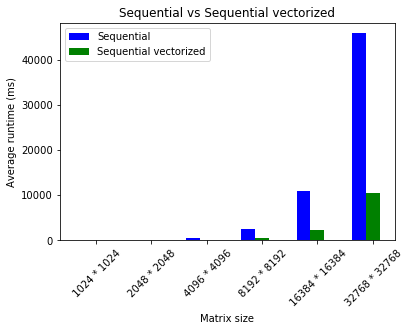

In [11]:
seq = df_sizes["relax-sequential.c"]
seq_vec = df_sizes["relax-sequential-vec.c"]

num_sizes = len(seq["Matrix size"].values[2:])

bar1 = np.arange(num_sizes)
bar2 = [x + 0.25 for x in bar1]

plt.figure()
plt.title("Sequential vs Sequential vectorized")
#Draw bars to figure
plt.bar(bar1, seq["Average runtime"][2:], color = "b", width = 0.25, label='Sequential')
plt.bar(bar2, seq_vec["Average runtime"][2:], color = "g", width = 0.25, label="Sequential vectorized")

#Labels
plt.xlabel("Matrix size")
plt.ylabel("Average runtime (ms)")

#X ticks
plt.xticks([r + 0.25 for r in range(num_sizes)],
        seq["Matrix size"].values[2:], rotation=45)

plt.legend()
plt.show()

In [12]:
seq

,Matrix size,Number of cores,Average runtime
0,256 * 256,1,6
1,512 * 512,1,16
2,1024 * 1024,1,55
3,2048 * 2048,1,156
4,4096 * 4096,1,615
5,8192 * 8192,1,2547
6,16384 * 16384,1,10881
7,32768 * 32768,1,45804


In [24]:
omp = df_sizes["relax-omp.c"]
omp_vec = df_sizes["relax-omp-vec.c"]



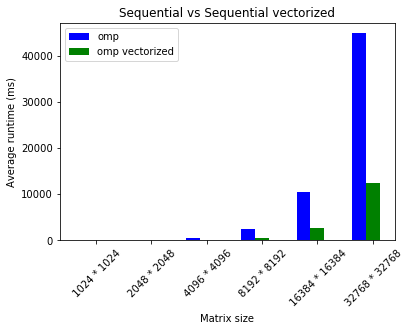

In [25]:
omp_1 = omp.loc[omp['Number of cores']==1]
omp_vec_1 = omp_vec.loc[omp['Number of cores']==1]
num_sizes = len(omp_1["Matrix size"].values[2:])

bar1 = np.arange(num_sizes)
bar2 = [x + 0.25 for x in bar1]

plt.figure()
plt.title("Core 1: Open MP vs Open MP vectorized")
#Draw bars to figure
plt.bar(bar1, omp_1["Average runtime"][2:], color = "b", width = 0.25, label='omp')
plt.bar(bar2, omp_vec_1["Average runtime"][2:], color = "g", width = 0.25, label="omp vectorized")

#Labels
plt.xlabel("Matrix size")
plt.ylabel("Average runtime (ms)")

#X ticks
plt.xticks([r + 0.25 for r in range(num_sizes)],
        omp_1["Matrix size"].values[2:], rotation=45)

plt.legend()
plt.show()


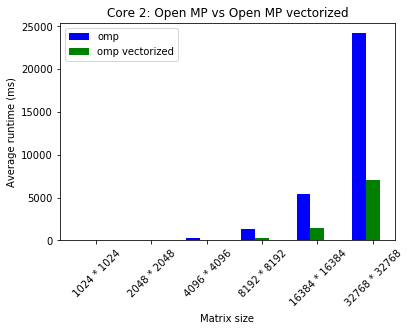

In [28]:
omp_2 = omp.loc[omp['Number of cores']==2]
omp_vec_2 = omp_vec.loc[omp['Number of cores']==2]
num_sizes = len(omp_2["Matrix size"].values[2:])

bar1 = np.arange(num_sizes)
bar2 = [x + 0.25 for x in bar1]

plt.figure()
plt.title("Core 2: Open MP vs Open MP vectorized")
#Draw bars to figure
plt.bar(bar1, omp_2["Average runtime"][2:], color = "b", width = 0.25, label='omp')
plt.bar(bar2, omp_vec_2["Average runtime"][2:], color = "g", width = 0.25, label="omp vectorized")

#Labels
plt.xlabel("Matrix size")
plt.ylabel("Average runtime (ms)")

#X ticks
plt.xticks([r + 0.25 for r in range(num_sizes)],
        omp_2["Matrix size"].values[2:], rotation=45)

plt.legend()
plt.show()

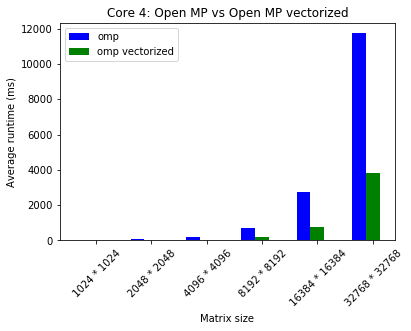

In [29]:
omp_4 = omp.loc[omp['Number of cores']==4]
omp_vec_4 = omp_vec.loc[omp['Number of cores']==4]
num_sizes = len(omp_4["Matrix size"].values[2:])

bar1 = np.arange(num_sizes)
bar2 = [x + 0.25 for x in bar1]

plt.figure()
plt.title("Core 4: Open MP vs Open MP vectorized")
#Draw bars to figure
plt.bar(bar1, omp_4["Average runtime"][2:], color = "b", width = 0.25, label='omp')
plt.bar(bar2, omp_vec_4["Average runtime"][2:], color = "g", width = 0.25, label="omp vectorized")

#Labels
plt.xlabel("Matrix size")
plt.ylabel("Average runtime (ms)")

#X ticks
plt.xticks([r + 0.25 for r in range(num_sizes)],
        omp_4["Matrix size"].values[2:], rotation=45)

plt.legend()
plt.show()

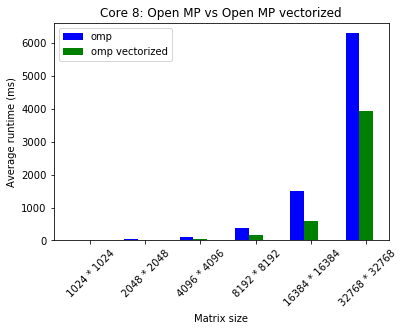

In [30]:
omp_8 = omp.loc[omp['Number of cores']==8]
omp_vec_8 = omp_vec.loc[omp['Number of cores']==8]
num_sizes = len(omp_8["Matrix size"].values[2:])

bar1 = np.arange(num_sizes)
bar2 = [x + 0.25 for x in bar1]

plt.figure()
plt.title("Core 8: Open MP vs Open MP vectorized")
#Draw bars to figure
plt.bar(bar1, omp_8["Average runtime"][2:], color = "b", width = 0.25, label='omp')
plt.bar(bar2, omp_vec_8["Average runtime"][2:], color = "g", width = 0.25, label="omp vectorized")

#Labels
plt.xlabel("Matrix size")
plt.ylabel("Average runtime (ms)")

#X ticks
plt.xticks([r + 0.25 for r in range(num_sizes)],
        omp_8["Matrix size"].values[2:], rotation=45)

plt.legend()
plt.show()

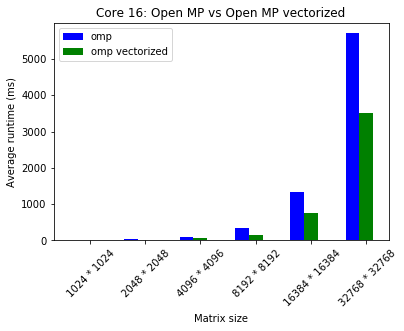

In [32]:
omp_16 = omp.loc[omp['Number of cores']==16]
omp_vec_16 = omp_vec.loc[omp['Number of cores']==16]
num_sizes = len(omp_16["Matrix size"].values[2:])

bar1 = np.arange(num_sizes)
bar2 = [x + 0.25 for x in bar1]

plt.figure()
plt.title("Core 16: Open MP vs Open MP vectorized")
#Draw bars to figure
plt.bar(bar1, omp_16["Average runtime"][2:], color = "b", width = 0.25, label='omp')
plt.bar(bar2, omp_vec_16["Average runtime"][2:], color = "g", width = 0.25, label="omp vectorized")

#Labels
plt.xlabel("Matrix size")
plt.ylabel("Average runtime (ms)")

#X ticks
plt.xticks([r + 0.25 for r in range(num_sizes)],
        omp_16["Matrix size"].values[2:], rotation=45)

plt.legend()
plt.show()

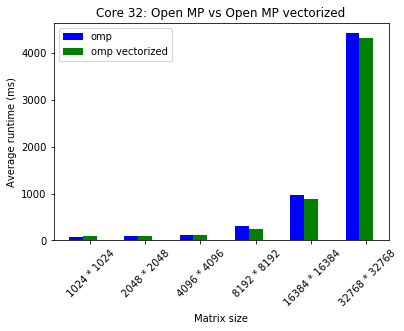

In [35]:
omp_32 = omp.loc[omp['Number of cores']==32]
omp_vec_32 = omp_vec.loc[omp['Number of cores']==32]
num_sizes = len(omp_32["Matrix size"].values[2:])

bar1 = np.arange(num_sizes)
bar2 = [x + 0.25 for x in bar1]

plt.figure()
plt.title("Core 32: Open MP vs Open MP vectorized")
#Draw bars to figure
plt.bar(bar1, omp_32["Average runtime"][2:], color = "b", width = 0.25, label='omp')
plt.bar(bar2, omp_vec_32["Average runtime"][2:], color = "g", width = 0.25, label="omp vectorized")

#Labels
plt.xlabel("Matrix size")
plt.ylabel("Average runtime (ms)")

#X ticks
plt.xticks([r + 0.25 for r in range(num_sizes)],
        omp_32["Matrix size"].values[2:], rotation=45)

plt.legend()
plt.show()

In [37]:
mpi = df_sizes["relax-mpi.c"]
mpi_vec = df_sizes["relax-mpi-vec.c"]


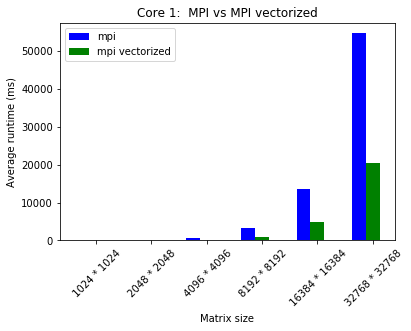

In [39]:
mpi_1 = mpi.loc[mpi['Number of cores']==1]
mpi_vec_1 = mpi_vec.loc[mpi['Number of cores']==1]
num_sizes = len(mpi_1["Matrix size"].values[2:])

bar1 = np.arange(num_sizes)
bar2 = [x + 0.25 for x in bar1]

plt.figure()
plt.title("Core 1:  MPI vs MPI vectorized")
#Draw bars to figure
plt.bar(bar1, mpi_1["Average runtime"][2:], color = "b", width = 0.25, label='mpi')
plt.bar(bar2, mpi_vec_1["Average runtime"][2:], color = "g", width = 0.25, label="mpi vectorized")

#Labels
plt.xlabel("Matrix size")
plt.ylabel("Average runtime (ms)")

#X ticks
plt.xticks([r + 0.25 for r in range(num_sizes)],
        mpi_1["Matrix size"].values[2:], rotation=45)

plt.legend()
plt.show()

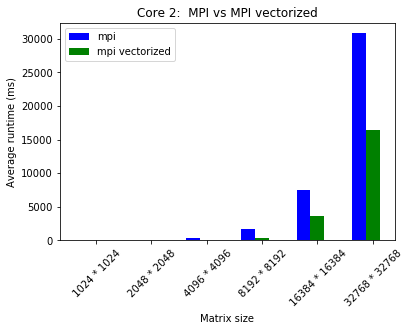

In [40]:
mpi_2 = mpi.loc[mpi['Number of cores']==2]
mpi_vec_2 = mpi_vec.loc[mpi['Number of cores']==2]
num_sizes = len(mpi_2["Matrix size"].values[2:])

bar1 = np.arange(num_sizes)
bar2 = [x + 0.25 for x in bar1]

plt.figure()
plt.title("Core 2:  MPI vs MPI vectorized")
#Draw bars to figure
plt.bar(bar1, mpi_2["Average runtime"][2:], color = "b", width = 0.25, label='mpi')
plt.bar(bar2, mpi_vec_2["Average runtime"][2:], color = "g", width = 0.25, label="mpi vectorized")

#Labels
plt.xlabel("Matrix size")
plt.ylabel("Average runtime (ms)")

#X ticks
plt.xticks([r + 0.25 for r in range(num_sizes)],
        mpi_2["Matrix size"].values[2:], rotation=45)

plt.legend()
plt.show()

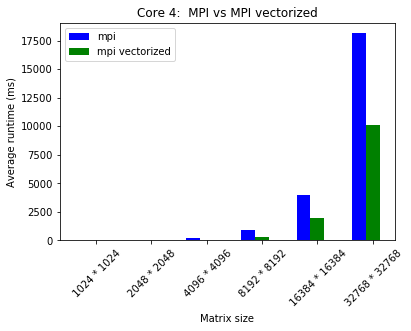

In [41]:
mpi_4 = mpi.loc[mpi['Number of cores']==4]
mpi_vec_4 = mpi_vec.loc[mpi['Number of cores']==4]
num_sizes = len(mpi_4["Matrix size"].values[2:])

bar1 = np.arange(num_sizes)
bar2 = [x + 0.25 for x in bar1]

plt.figure()
plt.title("Core 4:  MPI vs MPI vectorized")
#Draw bars to figure
plt.bar(bar1, mpi_4["Average runtime"][2:], color = "b", width = 0.25, label='mpi')
plt.bar(bar2, mpi_vec_4["Average runtime"][2:], color = "g", width = 0.25, label="mpi vectorized")

#Labels
plt.xlabel("Matrix size")
plt.ylabel("Average runtime (ms)")

#X ticks
plt.xticks([r + 0.25 for r in range(num_sizes)],
        mpi_4["Matrix size"].values[2:], rotation=45)

plt.legend()
plt.show()

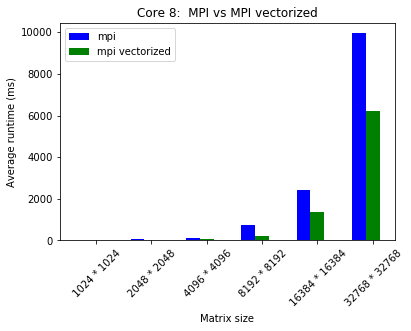

In [42]:
mpi_8 = mpi.loc[mpi['Number of cores']==8]
mpi_vec_8 = mpi_vec.loc[mpi['Number of cores']==8]
num_sizes = len(mpi_8["Matrix size"].values[2:])

bar1 = np.arange(num_sizes)
bar2 = [x + 0.25 for x in bar1]

plt.figure()
plt.title("Core 8:  MPI vs MPI vectorized")
#Draw bars to figure
plt.bar(bar1, mpi_8["Average runtime"][2:], color = "b", width = 0.25, label='mpi')
plt.bar(bar2, mpi_vec_8["Average runtime"][2:], color = "g", width = 0.25, label="mpi vectorized")

#Labels
plt.xlabel("Matrix size")
plt.ylabel("Average runtime (ms)")

#X ticks
plt.xticks([r + 0.25 for r in range(num_sizes)],
        mpi_8["Matrix size"].values[2:], rotation=45)

plt.legend()
plt.show()

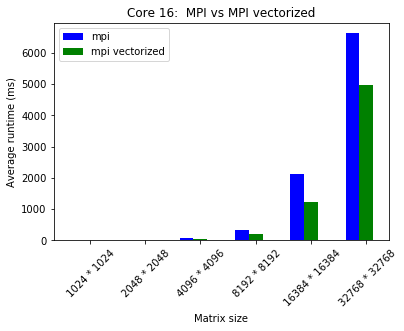

In [43]:
mpi_16 = mpi.loc[mpi['Number of cores']==16]
mpi_vec_16 = mpi_vec.loc[mpi['Number of cores']==16]
num_sizes = len(mpi_16["Matrix size"].values[2:])

bar1 = np.arange(num_sizes)
bar2 = [x + 0.25 for x in bar1]

plt.figure()
plt.title("Core 16:  MPI vs MPI vectorized")
#Draw bars to figure
plt.bar(bar1, mpi_16["Average runtime"][2:], color = "b", width = 0.25, label='mpi')
plt.bar(bar2, mpi_vec_16["Average runtime"][2:], color = "g", width = 0.25, label="mpi vectorized")

#Labels
plt.xlabel("Matrix size")
plt.ylabel("Average runtime (ms)")

#X ticks
plt.xticks([r + 0.25 for r in range(num_sizes)],
        mpi_16["Matrix size"].values[2:], rotation=45)

plt.legend()
plt.show()

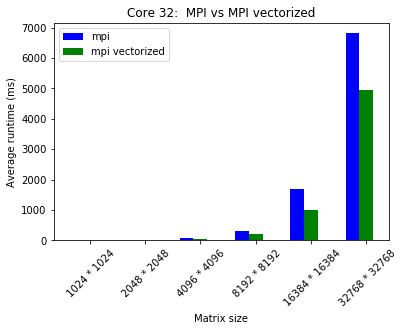

In [44]:
mpi_32 = mpi.loc[mpi['Number of cores']==32]
mpi_vec_32 = mpi_vec.loc[mpi['Number of cores']==32]
num_sizes = len(mpi_32["Matrix size"].values[2:])

bar1 = np.arange(num_sizes)
bar2 = [x + 0.25 for x in bar1]

plt.figure()
plt.title("Core 32:  MPI vs MPI vectorized")
#Draw bars to figure
plt.bar(bar1, mpi_32["Average runtime"][2:], color = "b", width = 0.25, label='mpi')
plt.bar(bar2, mpi_vec_32["Average runtime"][2:], color = "g", width = 0.25, label="mpi vectorized")

#Labels
plt.xlabel("Matrix size")
plt.ylabel("Average runtime (ms)")

#X ticks
plt.xticks([r + 0.25 for r in range(num_sizes)],
        mpi_32["Matrix size"].values[2:], rotation=45)

plt.legend()
plt.show()